# Exploratory Data Analysis of Freelance Profiles with relation to Hourly Rate

In [ ]:
# Notes to self:

# The clustering on skills didn't work because there isn't enough skills per user.
# Almost all users have about 5 skills, but there isn't enough overlap between them.
# Futhermore, there is just about no signal relating the features to hourly rate.
# Need to pivot and think of some alternative way to use this data.
# Also, I need to figure out why everyone has a "1" for their invoices paid.

# Do a regression tree model
# Deriving other features from the text
# Sentiment: Passive vs active voice?
# do the skills appear in the text 
# Try a targeted search and get numerics out
    # remove +'s' or try regex 
# Use text to look for those skills and maybe try to find words around it?
# Skills in text vs not in the skill list 
# Naively do some kind of embedding (word2vec)
    # Toss in their description and it creates a vector representation 
    # And then try looking at clusters in that space
    # Specify the length of the vector 

### Importing and Merging to get EDA Dataset

In [ ]:
# Packages for PostgreSQL Import and Export
from sqlalchemy_utils import database_exists, create_database
from sqlalchemy import create_engine
import psycopg2
import os

# Packages for EDA
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime
from nltk.corpus import stopwords
import re 

# Packages for K-Modes Cluster
from kmodes.kmodes import KModes

In [ ]:
# Ideally I'll move this into the project config.py file
# Otherwise for now I have to just manually assign . . .

dbname = "freelance_db"
username = os.environ['USER']
pswd = os.environ['SQLPSWD']

# Connect to Data
con = None
con = psycopg2.connect(database=dbname, user=username,
                       host='localhost', password=pswd)

# Checking shapes of tables
sql_query = """SELECT * from user_details_table;"""
dtls_table = pd.read_sql_query(sql_query, con)

sql_query = """SELECT * from freelance_table;"""
fl_table = pd.read_sql_query(sql_query, con)

In [3]:
# Merging
# Modifying profile_url in the details table so I can merge it with the fl_table
dtls_table['profile_url'] = "https://www.guru.com"+dtls_table['profile_url']

# Now I'm merging them together to make dt
dt = pd.merge(fl_table, dtls_table, on='profile_url')
dt.shape
dt = dt.drop(columns=(['index_x']))
dt = dt.drop_duplicates(subset='profile_url')

In [4]:
# Merging in data to crosswalk states with region labels
state_region_crswlk = pd.read_csv(
    '~/Desktop/Insight/projects/myrate/data/raw/census-regions/us census bureau regions and divisions.csv')
state_region_crswlk.head()

dt = pd.merge(dt, state_region_crswlk,
              how='left', left_on='state', right_on='State')

# Fixing region value for individuals living in Puerto Rico
dt.loc[dt['state'] == "Puerto Rico", 'Region'] = "Other"

# Exploratory Data Analysis - Outcome: Hourly Rate
### Beginning with investigating the geographic labels 

In [ ]:
# What is the overall mean?
print("Mean hourly rate ($):", round(dt['hourly_rate'].mean(), 2))

In [ ]:
# What is the mean by region?
dt.groupby(['Region']).hourly_rate.mean()

# There is some variation, but it is minimal

In [ ]:
# What is the mean across states?
dt.groupby(['state']).hourly_rate.mean().sort_values().describe()

# Pretty decent spread. This may be the most powerful signal yet.
# If you print out hte full table it is clear that there is variation

In [5]:
# What is the variation within states?
state_lvl_hourly_rate_descriptives = {}
state_lvl_hourly_rate_descriptives['min'] = dt.groupby(
    ['state']).hourly_rate.min()
state_lvl_hourly_rate_descriptives['mean'] = dt.groupby(
    ['state']).hourly_rate.mean()
state_lvl_hourly_rate_descriptives['max'] = dt.groupby(
    ['state']).hourly_rate.max()
state_lvl_hourly_rate_descriptives['var'] = dt.groupby(
    ['state']).hourly_rate.var()
dt_state_hr = pd.DataFrame(state_lvl_hourly_rate_descriptives)

# A decent amount of variation within the states

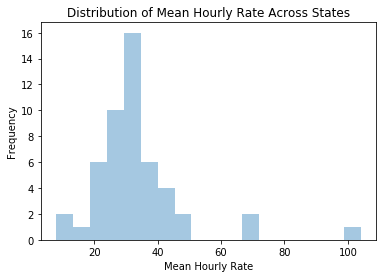

In [6]:
ax = sns.distplot(dt_state_hr['mean'], kde = False)
ax.set(xlabel='Mean Hourly Rate', ylabel='Frequency')
ax.set_title("Distribution of Mean Hourly Rate Across States")
plt.show()

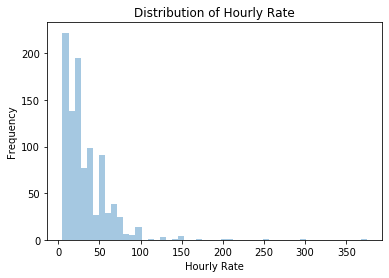

In [12]:
ax = sns.distplot(dt['hourly_rate'], kde = False)
ax.set(xlabel='Hourly Rate', ylabel='Frequency')
ax.set_title("Distribution of Hourly Rate")
plt.show()
fig = ax.get_figure()
fig.savefig("/Users/Metaverse/Desktop/Insight/presentation_materials/output.png") 


In [ ]:
# I tried to break it down further to the city level
# But the city data is really messy and not worth the time sink
# To try and get it set up. The idea would be to merge on
# rural vs urban and see if it can help me filter out a signal.

### Investigating the relationship between a users "rating" and the outcome

In [ ]:
# Cleaing it up real quick
dt.rating = dt.rating.str.replace('%', '')
dt.rating = dt.rating.str.replace('NA', '')
dt.rating = pd.to_numeric(dt.rating)

In [ ]:
# Starting with Missing Values
print("Number of missing values: ", dt.rating.isna().sum())

In [ ]:
# What does the spread look like for the rest?
dt.rating.describe()

# Basically no variation. Okay, let's make a binary variable (has_rating)

In [ ]:
# Creating "has_rating"
dt['has_rating'] = None
dt.loc[dt['rating'].isna(), 'has_rating'] = 0
dt.loc[dt['rating'] > 0, 'has_rating'] = 1

# Comparing outcome means by has_rating
dt.groupby(['has_rating']).hourly_rate.mean()

# Small difference, nothing substantial

### Exploring the duration of membership and hourly rate

1. Convert member start date to a date object
2. Calculate years / months they've been a member (to today)

In [ ]:
def date_convert(member_since):
    try:
        tmp = datetime.strptime(member_since, '%b, %Y')
        #tmp = tmp.strftime('%Y-%m')
    except:
        tmp = 'NaN'
    return tmp

In [ ]:
def years_active(date):
    cur_year = datetime.now().year
    try:
        yrs_active = cur_year - date.year
    except:
        yrs_active = 'NaN'

    return yrs_active

In [ ]:
def months_active(date):
    cur_year = datetime.now().year
    cur_month = datetime.now().month

    try:
        mnths_active = (cur_year - date.year)*12 + (cur_month - date.month)
    except:
        mnths_active = 'NaN'

    return mnths_active

In [ ]:
# Converting member_since to date
dt.member_since = dt.member_since.str.strip()
dt['start_date'] = dt.member_since.apply(date_convert)
dt['years_active'] = dt.start_date.apply(years_active)
dt['months_active'] = dt.start_date.apply(months_active)

# Therea are 31 NAs. Just going to ignore them for now.

In [ ]:
# What I want to understand is:
# How does the hourly rate (average) change across years active?
dt.groupby('years_active').hourly_rate.mean()

# Nothing much. It ramps up if years active > 17. Building that binary.

In [ ]:
dt['active_17up'] = (dt['years_active'] >= 17) * 1

In [ ]:
# Okay let's try looking at months active. Maybe on a finer scale there is some difference?
x = dt.groupby('months_active').hourly_rate.mean().index
y = dt.groupby('months_active').hourly_rate.mean()
ax = sns.scatterplot(x=x, y=y,
                     color='black')
ax.set(xlabel='months_active', ylabel='Average hourly_rate')
plt.show()

# No real pattern emerges. Unfortunately not useful.

### Exploring hourly rate and how it relates to the skills

1. Obtain the dataset that is long by skills and shrink it down to just the skills. I'll work with that for this.
2. Create some quick features such as: # of skills and top skill. These are user level so I can attach them back to dt to have everything in one place.

Note: the skills are standardized on guru which makes this more straightforward

In [ ]:
sql_query = """SELECT profile_url, skills_list from freelance_table;"""
skills_table = pd.read_sql_query(sql_query, con)
skills_table_dummies = pd.get_dummies(skills_table, columns=[
                                      'skills_list'], prefix='').groupby(['profile_url']).sum()

In [ ]:
# Number of skills
num_skills = skills_table.groupby('profile_url').count()
num_skills = num_skills.rename(columns={"skills_list": "num_skills"})
num_skills = num_skills.reset_index()

In [ ]:
# Merging num skills into dt
dt = pd.merge(dt, num_skills, on="profile_url")

In [ ]:
dt.groupby('num_skills').hourly_rate.mean()

In [ ]:
# Seems that for those with less than five skills listed
# they tend to have a lower hourly rate.
dt['less_five_skills'] = (dt['num_skills'] < 5) * 1

In [ ]:
# Moving on to something else. Let's look at the top skills (first skill listed)
first_skill = skills_table[skills_table.groupby(
    'profile_url')['skills_list'].cumcount() == 0]

first_skill = first_skill.rename(
    columns={"profile_url": "profile_url", "skills_list": "first_skill"})

dt = pd.merge(dt, first_skill, on="profile_url")

In [ ]:
# Exploring First Skills
print("Number of unique skills: ", dt.first_skill.nunique())
dt.groupby('first_skill').first_skill.count().describe()

# There is some repition but not much. Maybe I can get something off the extreme cases.

In [ ]:
# Exploring extreme first skill frequencies
skill_freq = {}
skill_freq['skill_frequency'] = dt.groupby(
    'first_skill').first_skill.count().sort_values(ascending=False)
skill_freq['skills_list'] = dt.groupby(
    'first_skill').first_skill.count().sort_values(ascending=False).index
skill_freq = pd.DataFrame(skill_freq)
skill_freq = skill_freq.reset_index()
skill_freq = skill_freq.drop(['first_skill'], axis=1)

dt = pd.merge(dt, skill_freq, on="skills_list")

In [ ]:
sns.scatterplot(x='skill_frequency', y='hourly_rate', data=dt)

# Nope, not much of anything here.

In [ ]:
# Just have to try to keep thinking of ways I could use this information.
# Ideally, I would be able to go group them by category and calculate hourly rate on that
# There may also be an interaction effect occuring between the category and something like
# years of experience.

### Starting the process of using the "bio" data

1. The easiest variable to create is the len(bio)
2. I'll have to try and expand it more using some other techniques

In [ ]:
def clean_bio(bio):
    try:
        cleaned_bio = ''.join(s for s in bio if ord(s) > 31 and ord(s) < 126)
    except:
        cleaned_bio = "NaN"
    return cleaned_bio

In [ ]:
def len_bio(bio):
    if bio == "NaN":
        return 0
    else:
        return len(bio)

In [ ]:
# Average word length in bio
def avg_word_ln(bio):
    try:
        words = bio.split()
        res = (sum(len(word) for word in words)/len(words))
    except:
        res = 0
    return res

In [ ]:
# Number of stop words
def num_stopwords(bio):
    stop = stopwords.words('english')

    try:
        res = len([x for x in bio.split() if x in stop])
    except:
        res = -1

    return res

In [ ]:
dt['bio_clean'] = dt.bio.apply(clean_bio)

In [ ]:
dt['bio_length'] = dt.bio_clean.apply(len_bio)

In [ ]:
len("Hi how are you doing today".split(" "))

In [ ]:
# Number of separate words in bio
dt['bio_word_count'] = dt['bio_clean'].apply(
    lambda x: len(str(x).split(" ")))

In [ ]:
dt['avg_word_length'] = dt['bio_clean'].apply(avg_word_ln)

In [ ]:
dt['num_stop'] = dt['bio_clean'].apply(num_stopwords)

In [ ]:
# Preprocessing before pulling more features

# Remvoing stop words
stop = stopwords.words('english')
dt['bio_processed'] = dt['bio_clean'].apply(
    lambda x: " ".join(x for x in x.split() if x not in stop))

# Removing punctuation
dt['bio_processed'] = dt['bio_processed'].str.replace(
    '[^\w\s]', '')

# Lower Case
dt['bio_processed'] = dt['bio_processed'].apply(
    lambda x: " ".join(x.lower() for x in x.split()))

In [ ]:
# Exploring how these bio features related to hourly rate

# Starting with the length of a users bio
sns.scatterplot(x='bio_length', y='hourly_rate', data=dt)

# Nothing.

In [ ]:
# How about how the word count related to hourly rate?
sns.scatterplot(x='bio_word_count', y='hourly_rate', data=dt)

# Nope, again nothing of interest here.

In [ ]:
# Okay, what about how word length
sns.scatterplot(x='hourly_rate', y='avg_word_length', data=dt)

# Hmm, no. But there are some very unusual outliers.

In [ ]:
# Lastly, the number of stop words
sns.scatterplot(x='num_stop', y='hourly_rate', data=dt)

In [ ]:
# Whole lot of nothing came out of the bio features.

### Comparing number of employers and hourly rate

Nevermind. There is no variance.

### Some final cleaning

In [ ]:
# Making State dummy variables
state_dummies = pd.get_dummies(dt['state'])
dt = pd.concat([dt, state_dummies], axis=1)

In [ ]:
# Earnings per Month
dt['earnings_ever'] = dt['earnings_ever'].str.replace('$', '')
dt['earnings_ever'] = dt['earnings_ever'].str.replace(',', '')
dt['earnings_ever'] = pd.to_numeric(dt['earnings_ever'])
dt['earnings_pr_month'] = dt['earnings_ever'] / \
    dt['months_active']

# Exploratory Data Analysis of Skills and Labels

### Goal: Merge scraped skills list and categories into data based on user reported skills

### Importing Data

In [ ]:
sql_query = """SELECT * from skills_categories_table;"""
sk_table = pd.read_sql_query(sql_query, con)
sk_table = sk_table.drop(['index'],axis = 1)

In [ ]:
# Extracting Numbers
sk_table['Skill_Frequency'] = pd.to_numeric(sk_table.Skills.str.extract(
    r'\((\d*?)\)').iloc[:, 0])

In [ ]:
# Cleaning Columns of frequency labels
sk_table['Skills_Clean'] = sk_table.Skills.str.replace(
    r'\((\d*?)\)','').str.strip().str.lower()
sk_table['Category'] = sk_table.Category.str.replace(
    r'\((.*?)\)','').str.strip().str.lower()
sk_table['Subcategory'] = sk_table.Subcategory.str.replace(
    r'\((\d*?)\)','').str.strip().str.lower()

In [ ]:
# Pulling in the user skills table
sql_query = """SELECT profile_url, skills_list from freelance_table;"""
skills_table = pd.read_sql_query(sql_query, con)

In [ ]:
skills_table['skills_list'] = skills_table['skills_list'].str.lower().str.strip()

In [ ]:
tmp = pd.merge(skills_table,sk_table,
               left_on='skills_list',right_on='Skills_Clean', how="left",
               indicator=True)

In [ ]:
# Now I want to try and see how many people match
# If they matched on at least one thing I can then expand that onto the rest of their data
tmp['matched'] = (tmp['_merge'] == "both") * 1
number_of_matches_by_user = tmp.groupby(['profile_url']).matched.sum()

In [ ]:
(number_of_matches_by_user == 0).sum()

# This is great, a good chunk of people matched.
# Now I can guess what field they were in (for the ones who matched)
# and then label the people similar to them

In [ ]:
tmp['num_matched'] = tmp.groupby(['profile_url']).matched.transform('sum')

In [ ]:
# So for people who matched, I want to determine which category most common for them
test = tmp[tmp['num_matched'] > 0][['profile_url','Category']]

In [ ]:
# Reshaping wide
# test['counter'] = test.groupby(['profile_url']).cumcount()+1
test['counter'] = 1
skill_category_matrix = test.pivot_table(index = 'profile_url', columns = 'Category', 
                     values = 'counter', aggfunc = 'sum', 
                     fill_value = 0)
skill_category_matrix.head()

# Quick Update: Working with Skill Categories

1. I now have a user-level matrix with the skill categories along the top
2. I also have a user-level matrix with skill categories along the top but with missing data.
3. I want to impute that matrix. How?
4. The simplest way would be to create the **very** wide skill matrix and do lookups for similarity.
    - For example, take skills vector (long, 0/1s) of user A who I want to impute his categories. Find the most similar vector among the users with data. Impute from there.

In [ ]:
# First resetting index on skill_category_matrix
skill_category_matrix = skill_category_matrix.reset_index()
skill_category_matrix['has_categories'] = 1

In [ ]:
# And creating skills dummy matrix
sql_query = """SELECT profile_url, skills_list from freelance_table;"""
skills_table = pd.read_sql_query(sql_query, con)
skills_table_dummies = pd.get_dummies(skills_table, columns=[
                                      'skills_list'], prefix='').groupby(['profile_url']).sum()
skills_table_dummies = skills_table_dummies.reset_index()

In [ ]:
# And merging
skills_table_dummies = pd.merge(skills_table_dummies, 
                                skill_category_matrix.loc[:,['profile_url','has_categories']], 
                                left_on = 'profile_url',
                                right_on = 'profile_url',
                                how = 'left')

In [ ]:
# Filling in the NA has_categories so it's a useful indicator
skills_table_dummies['has_categories'] = skills_table_dummies['has_categories'].fillna(0)

In [ ]:
has_cat = skills_table_dummies[skills_table_dummies['has_categories'] == 1]
no_cat = skills_table_dummies[skills_table_dummies['has_categories'] == 0]

In [ ]:
def raw_distance():
    sqrdist = np.sum(np.sqrt(np.square(user_no_cat-user_has_cat)))
    return sqrdist

In [ ]:
# Creating one long list of all distances
dist = []
for k in range(0,no_cat.shape[0]):
    if k%50 == 0 :
        print(k) 
    for j in range(0,has_cat.shape[0]):
        user_no_cat = np.array(list(no_cat.iloc[k,1:]))
        user_has_cat = np.array(list(has_cat.iloc[j,1:]))
        dist.append(raw_distance())

    

In [ ]:
# Putting that list into a numpy matrix of the appropriate shape
res = np.array(dist).reshape(no_cat.shape[0],has_cat.shape[0])

In [ ]:
# Finding where the FIRST minimum is for each user
# Come back later and clean this up to return multiple minimums
# Making my life easy for now . . .
min_indices = np.argmin(res, axis = 1) 

In [ ]:
min_indices[1]

In [ ]:
# Now I want to take the minimum index and use it on the has_cat table
# to look up the person with whom they have similar relationship.
# I can then extract this users row and slap it into a new table (impute_cat)
cols = list(skill_category_matrix.columns)[0:10]
impute_cat = pd.DataFrame(columns=cols)

impute_cat['profile_url'] = no_cat['profile_url']

for j in range(0,no_cat.shape[0]):
    impute_cat.iloc[j,1:] = skill_category_matrix.iloc[min_indices[j],1:10]

In [ ]:
# Append to skill_category_matrix
full_cat = skill_category_matrix.append(impute_cat)
full_cat = full_cat.drop(['has_categories'], axis = 1)
full_cat = full_cat.fillna(0)
# Done!

In [ ]:
# Saving this out so I don't have to run the calculation again . . .
engine = create_engine('postgresql://%s:%s@localhost/%s' %
                       (username, pswd, dbname))
full_cat.to_sql("full_cat_dt", engine, if_exists='replace')

### Skill Categories Update #2

1. I imputed the skill categories using the L2 norm to find similar users
2. Now I have a user level matrix with the skill category and the number of skills they have in it.
3. However, the number is a little misleading because sometimes they just didn't match on their other listed skills.
4. Therefore, I now have the question of:
    - Do I create dummies for whether or not they have a certain category, at all?
    - Or do I pick the one they have the largest value in?
    - I think I may just do dummies for now. This means I just need to make any value > 0 = 1
5. Anyways, the next step is to explore the mean hourly_rate by skill categories.

In [ ]:
# Merging it into the data
dt = pd.merge(dt, full_cat, on="profile_url")

In [ ]:
# Making Binary Dummies
cols = list(dt.columns[-9:])
for j in range(0,len(cols)):
    dt.loc[dt[cols[j]] > 0, cols[j]] = 1

### Exploring the relationship between skill categories and hourly rate

In [ ]:
for j in range(0,len(cols)):
    print(dt.groupby(cols[j]).hourly_rate.mean())
    
# For Engineering, Legal, programming, there is a marked difference.

### Saving out Modified Dataset

1. First printing the columns I have for reference.
2. Saving it to a new table in the postgreSQL database

In [ ]:
dt.head()

In [ ]:

dt.info()

In [ ]:
col_locs = [4,6,21,24,26,31,32,33,34]
x = list(range(36,86))
y = list(range(87,96))
col_locs.extend(x)
col_locs.extend(y)
print(col_locs)

In [ ]:
# Cleaning to just variables that will be used in the model
analysis_dt = dt.iloc[:,col_locs]
analysis_dt = analysis_dt.dropna()  # Removing people with NA
analysis_dt.info()

In [ ]:
# Connect to the database and save data to it
engine = create_engine('postgresql://%s:%s@localhost/%s' %
                       (username, pswd, dbname))
analysis_dt.to_sql("analysis_table", engine, if_exists='replace')

### OLD: Working on clustering the skills

1. This didn't work. I think the reason is because I don't have enough skills for each user. Therefore, it can't find enough similarity between them. Maybe I could go back and jump into each users url and scrape their entire skills list? Time consuming.

In [ ]:
# Found K-Modes on stackoverflow
# Following the package documentation
# Ref: https://pypi.org/project/kmodes/
# Ref: https://stackoverflow.com/questions/42639824/python-k-modes-explanation
# Ref: https://www.kaggle.com/ashydv/bank-customer-clustering-k-modes-clustering

In [ ]:
# Cleaning column names from the dummies database
skills_table_dummies.columns = skills_table_dummies.columns.str.strip().str.lower().str.replace(
    ' ', '_').str.replace('(', '').str.replace(')', '').str.replace('_', '')

In [ ]:
skills_table_dummies.head()

In [ ]:
# Modeling with K Modes
cost = []
for num_clusters in list(range(20, 30)):
    kmode = KModes(n_clusters=num_clusters, init="Huang", verbose=0)
    kmode.fit_predict(skills_table_dummies)
    cost.append(kmode.cost_)
    print("Finished Cluster: " + str(num_clusters))

In [ ]:
y = np.array([i for i in range(20, 30, 1)])
plt.plot(y, cost)

In [ ]:
kmode = KModes(n_clusters=28, init='Huang', verbose=0)
clusters = kmode.fit_predict(skills_table_dummies)

kmodes = kmode.cluster_centroids_
shape = kmodes.shape

for i in range(shape[0]):
    if sum(kmodes[i, :]) == 0:
        print("\ncluster " + str(i) + ": ")
        print("no-skills cluster")
    else:
        print("\ncluster " + str(i) + ": ")
        cent = kmodes[i, :]
        for j in skills_table_dummies.columns[np.nonzero(cent)]:
            print(j)

In [ ]:
clust_assigned = km.predict(skills_table_dummies)

In [ ]:
unique, counts = np.unique(clust_assigned, return_counts=True)
dict(zip(unique, counts))

In [ ]:
user_cluster_crosswalk = pd.DataFrame(
    skills_table['profile_url'].unique(), columns=["profile_url"]).sort_values(by="profile_url")
user_cluster_crosswalk['cluster'] = clust_assigned
user_cluster_crosswalk[user_cluster_crosswalk['cluster'] == 0].head()

In [ ]:
# Merging into the skills table to investigate those with "no skills"
tmp = pd.merge(skills_table, user_cluster_crosswalk, on="profile_url")
tmp[tmp['cluster'] == 0]

In [ ]:
# It seems to not be working great.
# Why is it putting so many people into the no skills cluster?

# EDA for the Probability of Getting a Job (0/1)

### Outcome: Probability of getting a job  . . . ever?

1. Need to clean all of this up

In [ ]:
# What about the (obvious) relationship between memebershp time and # of jobs completed
# How strong is the relationship?
# First have to clean the invoices paid variable
dt.invoices_paid = dt.invoices_paid.str.replace(',', '')
dt.invoices_paid = pd.to_numeric(dt.invoices_paid)
dt.invoices_paid.describe()

In [ ]:
# Who is NA? I have a whole bunch of 1s but then some NAs?
# The question for a poisson model is: did they just have no invoices OR
# were they never going to have any invoices.
# Looked at some of them and I'll treat them as zeros. So there are really that many ones?!?
dt[dt.invoices_paid.isna()].head()

In [ ]:
# Assigning zero to the NAs. This is important!!
dt.loc[dt.invoices_paid.isna(), 'invoices_paid'] = 0

In [ ]:
sns.distplot(dt.invoices_paid)

In [ ]:
# Wow, very heavy on the zeros. Let's look closer.
dt.invoices_paid.describe()

In [ ]:
# Ah, so it is truncating at one.
# This is going to be problematic for those who are actually at a value of one.
# I can either rerun the scrape and create something to make the val = 0
# or I can just move forward. . .

# For now I'm going to keep moving forward and treat 1 as 0.
# Note, it is more likely than not that they are = 0

In [ ]:
# Checking dist vs months active (no 1s)
sns.scatterplot(x='months_active', y='invoices_paid',
                data=dt[dt.invoices_paid > 1])

In [ ]:
# A few massive outliers. Going to rough chop it down and replot
invoice_gtr_one = dt.invoices_paid > 1
invoice_ls_2000 = dt.invoices_paid < 2000
sns.scatterplot(x='months_active', y='invoices_paid',
                data=dt[invoice_gtr_one & invoice_ls_2000])

In [ ]:
# hmm, there may be a slight signal but you would expect a stronger trend

In [ ]:
# Checking dist vs years active (no 1s)
sns.scatterplot(x='years_active', y='invoices_paid',
                data=dt[invoice_gtr_one & invoice_ls_2000])
# Slight postive non-linear trend bu there is a HUGE outlier

### Invoices Paid - Notes

It has a weak-ish relationship with time. There are a lot of really heavy users of the platform that dominate the market. Let's zoom into the first year and see what it looks like.

In [ ]:
# Looking at invoices pad in the first few months (among those only active for a shorter period of time)
sns.scatterplot(x='months_active',
                y='invoices_paid',
                data=dt[dt['years_active'] < 2])

In [ ]:
# Calculating invoices / time active
dt['invoices_per_month'] = dt['invoices_paid'] / \
    dt['months_active']
sns.distplot(dt.invoices_per_month)
print(dt.invoices_per_month.describe())

In [ ]:
# Loaded on zero with a long tail. Continues to sell that there are some serious power users.
# Average invoice per month is equal to one, but I left in the 1s that could be zeros. . .
# Real average is likely near zero.

# The question now is: Does this mean differ by any characteristic that I observe in the data?
# For people with a different skill set (Andriod) do they have a higher mean invoice/month rate?
# For people in different regions do they have a higher mean invoice/month rate?
# For people with lower hourly rates do they have a higher mean invoice/month rate??

# The next important step is to figure out how to use the skills data.
# It would be great to try and create clusters of the skills.